<h1 style="color: orange;">LightGBM Model with Native Categorical Handling</h1>

<h2 style="color: green;">Installation Instructions</h2>
<p style="color: gray;">
Before getting started, please ensure you have installed all the necessary packages. Run the following commands in your terminal:
</p>
<pre style="color: gray;">
pip install lightgbm
pip install scikit-learn
pip install pandas numpy matplotlib seaborn
</pre>

<h2 style="color: green;">Introduction</h2>
<p style="color: gray;">
In this notebook, we build and tune a <strong>LightGBM</strong> model for our dataset. LightGBM is particularly efficient and can handle categorical features natively—provided that these features are converted to the appropriate type (e.g., pandas <code>category</code>). This notebook focuses on a randomized search to optimize the model's performance.
</p>

<h2 style="color: green;">Objectives</h2>
<ul>
  <li style="color: gray;">Preprocess the data by filling missing values and converting categorical features to the <code>category</code> dtype.</li>
  <li style="color: gray;">Construct a LightGBM model that leverages native categorical handling without extra encoding.</li>
  <li style="color: gray;">Perform hyperparameter tuning using RandomizedSearchCV to broadly explore parameter space.</li>
  <li style="color: gray;">Evaluate the model performance using ROC curves, confusion matrices, and other metrics.</li>
</ul>

<h2 style="color: green;">Dataset</h2>
<p style="color: gray;">
Our dataset contains multiple features, including several categorical variables. These categorical features will be converted to the <code>category</code> type in pandas, allowing LightGBM to process them natively without the need for manual encoding.
</p>

<h2 style="color: green;">Methodology</h2>
<ol>
  <li style="color: gray;">Data Preprocessing: Fill missing values and convert categorical columns to <code>category</code>.</li>
  <li style="color: gray;">Randomized Search: Quickly explore a wide range of hyperparameters.</li>
  <li style="color: gray;">Model Evaluation: Assess performance with ROC curves, confusion matrices, and other metrics.</li>
</ol>

<h2 style="color: green;">Let's Get Started!</h2>


<h3 style="color: Gray;"> 📌 1. Import libraries</h3>

In [ ]:
#Data maipulation
import pandas as pd
import numpy as np
import pickle


#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

#Data modelization
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV#, GridSearchCV (not used due to time of training)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shap


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3 style="color: Gray;"> 📌 2. Load Data & Define Target </h3>

In [2]:
#Loading my dataset 
with open("/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/data/exp_data.pkl", "rb") as f:
    df = pickle.load(f, fix_imports=True)
    
print(df.head(2))
df.info()


  State    Zip BankState  ApprovalFY  Term  NoEmp  NewExist  CreateJob  \
0    IN  47711        OH        1997    84      4       1.0          0   
1    IN  46526        IN        1997    60      2       1.0          0   

   RetainedJob  FranchiseCode  UrbanRural  RevLineCr  LowDoc  \
0            0              0           0        0.0     1.0   
1            0              0           0        0.0     1.0   

   DisbursementGross  MIS_Status   GrAppv ApprovalMonth NAICS_CODE  
0            60000.0           0  60000.0             2         45  
1            40000.0           0  40000.0             2         72  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              899162 non-null  object 
 1   Zip                899164 non-null  object 
 2   BankState          897598 non-null  object 
 3   ApprovalFY      

In [5]:
#  Define a helper function to convert binary columns
def convert_binary(X):
    X = X.copy()
    binary_cols = ["RevLineCr", "LowDoc", "NewExist"]
    for col in binary_cols:
        if col in X.columns:
            X[col] = X[col].astype(int)
    return X

In [ ]:

# --- Data Preparation ---

target = "MIS_Status"
X = df.drop(columns=[target])
y = df[target]

# Columns to impute
cols_to_impute = ['State','RevLineCr', 'LowDoc', 'BankState', 'NewExist']
imputer = SimpleImputer(strategy='most_frequent')
X[cols_to_impute] = imputer.fit_transform(X[cols_to_impute])
# Assuming X is your feature DataFrame
X = convert_binary(X)

# Then split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Identify categorical columns (for target encoding)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

<h3 style="color: Gray;"> 📌 3. RandomizedSearchCV </h3>

In [8]:
# (Optional) Determine categorical feature indices – LightGBM's sklearn API can use these


# **Convert categorical columns to category dtype**
for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Determine categorical feature indices (optional, but helpful)
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_cols]

# --- Define the LightGBM model ---
# LightGBM will use the native handling for categorical features if the columns have category dtype.
# You can also pass categorical_feature=cat_feature_indices to the model.
model = LGBMClassifier(
    random_state=42,
    categorical_feature=cat_feature_indices  # optional if columns are already category dtype
)

# --- Define Hyperparameter Distributions for Randomized Search ---
param_distributions = {
    "n_estimators": np.arange(50, 300, 50),       # e.g., 50, 100, 150, 200, 250
    "learning_rate": np.linspace(0.01, 0.2, 10),   # 10 values between 0.01 and 0.2
    "num_leaves": np.arange(20, 150, 10),          # try values from 20 up to 140
    "max_depth": np.arange(3, 12, 1)               # depths from 3 to 11
}

# --- Run RandomizedSearchCV ---
rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,         # adjust for speed; you might try 10 or fewer iterations initially
    cv=3,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)

print("Best parameters from RandomizedSearchCV:")
print(rs.best_params_)

# --- Evaluate the Best Model from Randomized Search ---
best_lgbm_rs = rs.best_estimator_
y_pred = best_lgbm_rs.predict(X_test)
y_pred_proba = best_lgbm_rs.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"AUC Score: {auc_score:.4f}")
print(report)
print("Confusion Matrix:")
print(cm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/Loan_Projet_

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM]

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14247
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175517 -> initscore=-1.547022
[LightGBM] [Info] Start training from score -1.547022


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94692, number of negative: 444806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.483430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14247
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175517 -> initscore=-1.547022
[LightGBM] [Info] Start training from score -1.547022


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.475982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14267
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175517 -> initscore=-1.547022
[LightGBM] [Info] Start trainin

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94692, number of negative: 444806
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.500595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] [binary:Boos

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.425583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14267
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromS

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94692, number of negative: 444806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.513585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromS

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.406539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14247
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175517 -> initscore=-1.547022
[LightGBM] [Info] Start trainin

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.444532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14267
[LightGBM] [Info] Number of data points in the train se

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94692, number of negative: 444806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.423498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175519 -> initscore=-1.547009
[LightGBM] [Info] Start training from score -1.547009
[LightGBM] [Warning] No further splits with positive

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.357929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14247
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175517 -> initscore=-1.547022
[LightGBM] [Info] Start training from score -1.547022
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Warning] No further splits with positive

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94692, number of negative: 444806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.432379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train se

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.443420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14247
[LightGBM] [Info] Number of data points in the train se

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94691, number of negative: 444807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.414592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 94692, number of negative: 444806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.513314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 539498, number of used features: 17
[LightGBM] [Info] [binary:BoostFromS

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,15,16, categorical_column=0,1,2,15,16 will be ignored. Current value: categorical_feature=0,1,2,15,16
[LightGBM] [Info] Number of positive: 142037, number of negative: 667210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14266
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.175517 -> initscore=-1.547017
[LightGBM] [Info] Start training from score -1.547017
Best parameters from RandomizedSearchCV:
{'num_leav

<h3 style="color: Gray;"> 📌 4. Exporting our model </h3>

In [10]:
# Define the export directory.
import os
import pickle

export_dir = '/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/'
os.makedirs(export_dir, exist_ok=True)  # create the directory if it doesn't exist

# Assuming your best grid model is stored in best_catboost_gs:
file_path = os.path.join(export_dir, 'lightgbm_best_grid_model.pkl')
with open(file_path, "wb") as f:
    pickle.dump(best_lgbm_rs, f)
print(f"Exported grid model to {file_path}")


Exported grid model to /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/lightgbm_best_grid_model.pkl


<h3 style="color: Gray;"> 📌 5. DataViz of our model </h3>

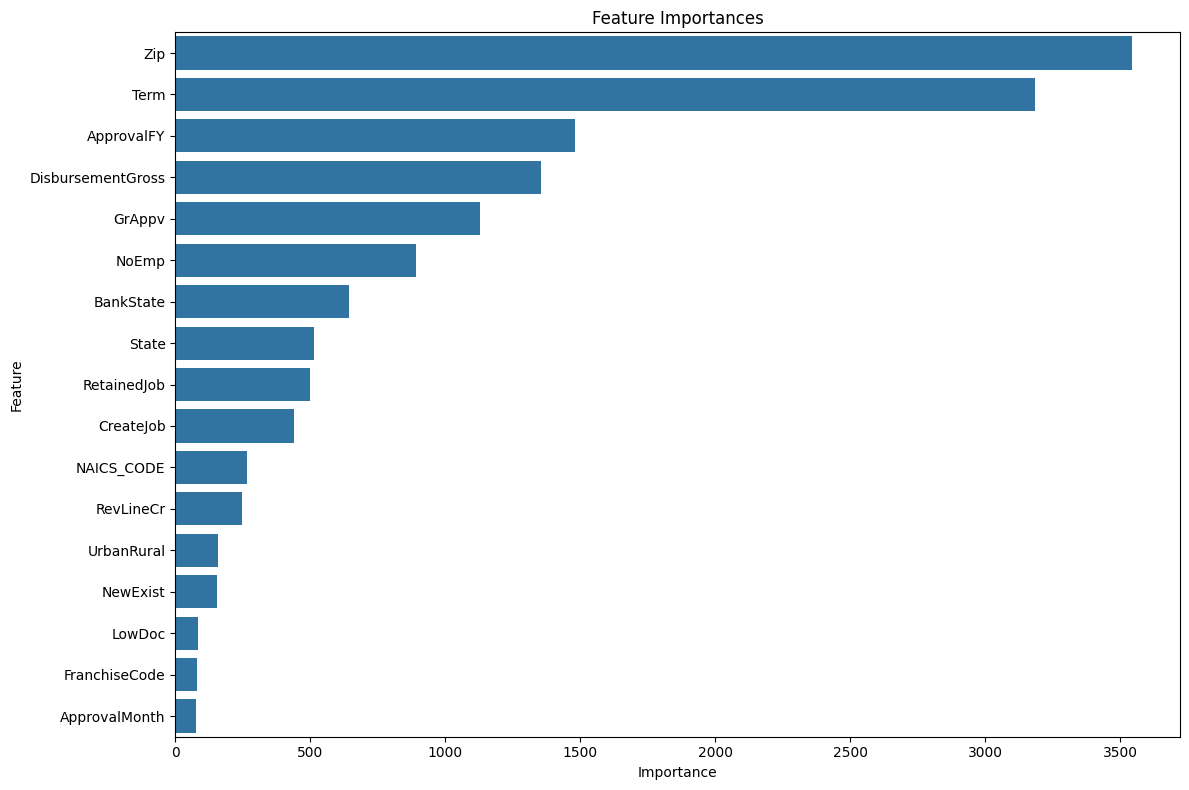

In [ ]:
# Get feature importances from the LightGBM model using the attribute
feature_importances = best_lgbm_rs.feature_importances_

# Create a DataFrame for plotting (We use  X_train.columns to get the feature names)
feat_imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


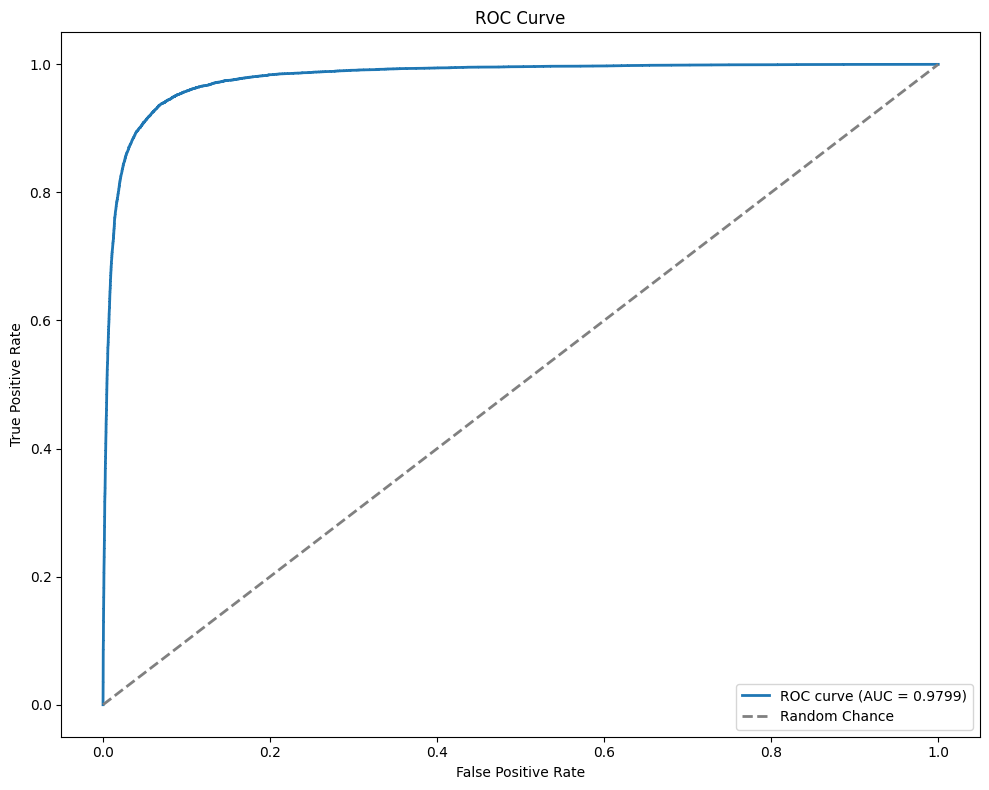

In [ ]:
# Get predicted probabilities for the positive class
y_pred_proba = best_lgbm_rs.predict_proba(X_test)[:, 1]

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc_value:.4f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


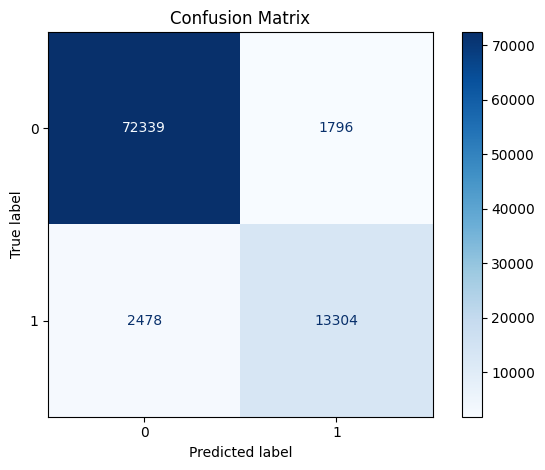

In [14]:

# Generate predictions
y_pred = best_lgbm_rs.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


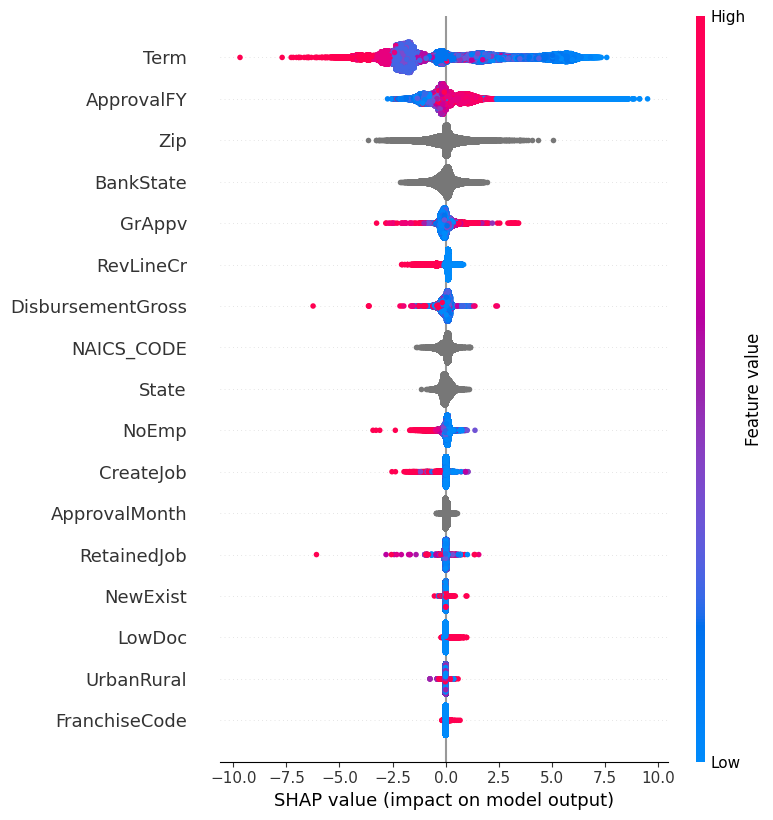

In [15]:

# Create a TreeExplainer for the LightGBM model
explainer = shap.TreeExplainer(best_lgbm_rs)

# Compute SHAP values for the test set
# For binary classification, shap_values is a single array.
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP summary plot (beeswarm plot)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)